In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models, callbacks, Model
from tensorflow.keras.applications import EfficientNetV2B0, DenseNet121
import cv2


In [2]:
# Load and prepare data with enhanced validation
df_1and2 = pd.read_csv('burns_1and2.csv')
df_3 = pd.read_csv('burns_3rd.csv')

# Assign labels
df_1and2['binary_label'] = 0
df_3['binary_label'] = 1

# Combine with better balancing
df_all = pd.concat([df_1and2, df_3], ignore_index=True)

# Check for valid file paths
def check_file_exists(filepath):
    return os.path.exists(filepath)

df_all['file_exists'] = df_all['filepath'].apply(check_file_exists)
df_all = df_all[df_all['file_exists']].reset_index(drop=True)

print(f"Valid samples after file check: {len(df_all)}")
print(df_all['binary_label'].value_counts())

# Enhanced stratified split with validation
train_df, temp_df = train_test_split(
    df_all, test_size=0.3, stratify=df_all['binary_label'], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['binary_label'], random_state=42
)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Valid samples after file check: 5899
binary_label
0    4876
1    1023
Name: count, dtype: int64
Train: 4129, Val: 885, Test: 885


In [3]:
# Enhanced parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 8  # Smaller for memory efficiency with ensemble
NUM_CLASSES = 1

# Calculate enhanced class weights with more aggressive weighting
y_train = train_df['binary_label'].values
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# More aggressive class weights for better minority class detection
class_weights = {0: 0.4, 1: 4.0}  # Higher weight for 3rd degree burns

# Add focal loss weight (higher penalty for hard examples)
focal_alpha = 0.25
focal_gamma = 2.0

print("Class distribution in train:")
print(train_df['binary_label'].value_counts())
print(f"Class weights: {class_weights}")

Class distribution in train:
binary_label
0    3413
1     716
Name: count, dtype: int64
Class weights: {0: 0.4, 1: 4.0}


In [4]:
def medical_enhance_image(image_path, target_size=IMG_SIZE):
    """Medical-grade image enhancement for burn classification"""
    try:
        # Load image
        img = cv2.imread(image_path)
        if img is None:
            return np.zeros((*target_size, 3), dtype=np.float32)
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Step 1: Enhance contrast and color more aggressively
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))  # Increased clip limit
        lab[:, :, 0] = clahe.apply(lab[:, :, 0])
        img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        
        # Step 2: Adaptive histogram equalization
        img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        
        # Step 3: Smart resize with padding
        h, w = img.shape[:2]
        scale = min(target_size[0] / w, target_size[1] / h)
        new_w, new_h = int(w * scale), int(h * scale)
        
        img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LANCZOS4)
        
        # Center padding
        delta_w = target_size[0] - new_w
        delta_h = target_size[1] - new_h
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)
        
        img = cv2.copyMakeBorder(img, top, bottom, left, right, 
                                cv2.BORDER_REFLECT, value=[0, 0, 0])
        
        # Step 4: Stronger noise reduction
        img = cv2.bilateralFilter(img, 15, 100, 100)  # More aggressive filtering
        
        # Normalize to [0, 1]
        img = img.astype(np.float32) / 255.0
        
        return img
    
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return np.zeros((*target_size, 3), dtype=np.float32)

def advanced_augmentation(img, strong_aug=True):
    """Enhanced augmentation for medical images"""
    if not strong_aug:
        return img
    
    # More aggressive geometric augmentations
    if np.random.random() > 0.4:  # Increased probability
        img = np.fliplr(img)
    
    if np.random.random() > 0.5:  # Increased probability
        angle = np.random.uniform(-25, 25)  # Wider range
        h, w = img.shape[:2]
        center = (w // 2, h // 2)
        matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        img = cv2.warpAffine(img, matrix, (w, h), borderMode=cv2.BORDER_REFLECT)
    
    # More aggressive color augmentations
    if np.random.random() > 0.3:  # Increased probability
        alpha = np.random.uniform(0.6, 1.4)  # Wider range
        beta = np.random.uniform(-0.2, 0.2)  # Wider range
        img = np.clip(alpha * img + beta, 0, 1)
    
    if np.random.random() > 0.4:  # Increased probability
        hsv = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
        hsv[:, :, 0] = (hsv[:, :, 0] + np.random.randint(-15, 15)) % 180  # Wider range
        img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB).astype(np.float32) / 255.0
    
    # Enhanced medical-specific augmentations
    if np.random.random() > 0.6:
        center_x, center_y = img.shape[1] // 2, img.shape[0] // 2
        y, x = np.ogrid[:img.shape[0], :img.shape[1]]
        mask = ((x - center_x) ** 2 + (y - center_y) ** 2) ** 0.5
        mask = mask / np.max(mask)
        lighting_factor = 1 + 0.4 * (1 - mask) * np.random.uniform(-1, 1)  # Stronger effect
        img = np.clip(img * lighting_factor[:, :, np.newaxis], 0, 1)
    
    return img



In [5]:

class EnsembleDataGenerator(Sequence):
    def __init__(self, df, batch_size=BATCH_SIZE, augment=True, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.df))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indexes]
        
        images = []
        labels = []
        
        for _, row in batch_df.iterrows():
            try:
                img = medical_enhance_image(row['filepath'])
                if self.augment:
                    img = advanced_augmentation(img, strong_aug=True)
                
                images.append(img)
                labels.append(row['binary_label'])
            except Exception as e:
                print(f"Error processing {row['filepath']}: {e}")
                # Add a black image as fallback
                images.append(np.zeros((*IMG_SIZE, 3), dtype=np.float32))
                labels.append(row['binary_label'])
        
        return np.array(images), np.array(labels)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Create generators with better error handling
train_gen = EnsembleDataGenerator(train_df, batch_size=BATCH_SIZE, augment=True)
val_gen = EnsembleDataGenerator(val_df, batch_size=BATCH_SIZE, augment=False, shuffle=False)
test_gen = EnsembleDataGenerator(test_df, batch_size=BATCH_SIZE, augment=False, shuffle=False)

In [6]:
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        
        focal_loss = -alpha_t * tf.math.pow((1 - p_t), gamma) * tf.math.log(p_t)
        return tf.reduce_mean(focal_loss)
    
    return focal_loss_fixed

def precision_metric(y_true, y_pred):
    threshold = 0.5
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    
    true_positives = tf.reduce_sum(y_true * y_pred)
    predicted_positives = tf.reduce_sum(y_pred)
    
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall_metric(y_true, y_pred):
    threshold = 0.5
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    
    true_positives = tf.reduce_sum(y_true * y_pred)
    actual_positives = tf.reduce_sum(y_true)
    
    recall = true_positives / (actual_positives + tf.keras.backend.epsilon())
    return recall

def f1_metric(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    
    f1 = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
    return f1

In [7]:
def create_efficientnet_branch():
    """EfficientNetV2 branch"""
    base_model = EfficientNetV2B0(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )
    
    # Fine-tune last layers
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    
    inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(64, activation='swish', name='efficientnet_features',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    
    return Model(inputs, outputs, name='efficientnet_branch')

def create_densenet_branch():
    """DenseNet branch"""
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )
    
    # Fine-tune last layers
    for layer in base_model.layers[:-15]:
        layer.trainable = False
    
    inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(64, activation='relu', name='densenet_features',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    
    return Model(inputs, outputs, name='densenet_branch')

def create_cnn_branch():
    """Custom CNN branch for medical features"""
    inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
    
    # Medical-focused conv layers
    x = layers.Conv2D(32, (7, 7), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(64, (5, 5), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(64, activation='relu', name='cnn_features',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    
    return Model(inputs, outputs, name='cnn_branch')

def create_ensemble_model():
    """Create ensemble model combining all branches"""
    inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
    
    # Create branches
    efficientnet_branch = create_efficientnet_branch()
    densenet_branch = create_densenet_branch()
    cnn_branch = create_cnn_branch()
    
    # Get features from each branch
    efficientnet_features = efficientnet_branch(inputs)
    densenet_features = densenet_branch(inputs)
    cnn_features = cnn_branch(inputs)
    
    # Combine features
    combined = layers.Concatenate()([efficientnet_features, densenet_features, cnn_features])
    
    # Final classification layers with L2 regularization
    x = layers.Dense(128, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001))(combined)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(64, activation='swish', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    # Multi-head output for better learning
    main_output = layers.Dense(1, activation='sigmoid', name='main_output')(x)
    aux_output = layers.Dense(1, activation='sigmoid', name='aux_output')(efficientnet_features)
    
    model = Model(inputs=inputs, outputs=[main_output, aux_output])
    return model

# Create ensemble model
ensemble_model = create_ensemble_model()
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnet_branch (Functiona  (None, 64)          6097168     ['input_1[0][0]']                
 l)                                                                                               
                                                                                                  
 densenet_branch (Functional)   (None, 64)           7181568     ['input_1[0][0]']                
                                                                                              

In [8]:
# Advanced optimizer with lower learning rate
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.00005,  # Lower learning rate for better convergence
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-8
)

# Compile with multiple outputs
ensemble_model.compile(
    optimizer=optimizer,
    loss={
        'main_output': focal_loss(alpha=focal_alpha, gamma=focal_gamma),
        'aux_output': 'binary_crossentropy'
    },
    loss_weights={'main_output': 1.0, 'aux_output': 0.3},
    metrics={
        'main_output': ['accuracy', precision_metric, recall_metric, f1_metric],
        'aux_output': ['accuracy']
    }
)

# Fixed prepare_targets function with infinite loop
def prepare_targets(generator):
    while True:  # Critical fix - infinite loop
        for batch_x, batch_y in generator:
            yield batch_x, {'main_output': batch_y, 'aux_output': batch_y}

train_gen_multi = prepare_targets(train_gen)
val_gen_multi = prepare_targets(val_gen)

# Enhanced callbacks
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_main_output_f1_metric',
        patience=10,  # Increased patience
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        'best_ensemble_model_v3.h5',
        monitor='val_main_output_f1_metric',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_main_output_loss',
        factor=0.2,  # More aggressive reduction
        patience=5,
        min_lr=1e-8,
        verbose=1,
        cooldown=3
    )
]

# Train ensemble model with more epochs
history = ensemble_model.fit(
    train_gen_multi,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen_multi,
    validation_steps=len(val_gen),
    epochs=50,  # Increased epochs
    callbacks=callbacks_list,
    verbose=1
)

Epoch 1/50
517/517 [==============================] - ETA: 0s - loss: 1.6552 - main_output_loss: 0.3581 - aux_output_loss: 0.6170 - main_output_accuracy: 0.5263 - main_output_precision_metric: 0.1922 - main_output_recall_metric: 0.4236 - main_output_f1_metric: 0.2470 - aux_output_accuracy: 0.6665               
Epoch 1: val_main_output_f1_metric improved from -inf to 0.28444, saving model to best_ensemble_model_v3.h5
517/517 [==============================] - 79s 141ms/step - loss: 1.6552 - main_output_loss: 0.3581 - aux_output_loss: 0.6170 - main_output_accuracy: 0.5263 - main_output_precision_metric: 0.1922 - main_output_recall_metric: 0.4236 - main_output_f1_metric: 0.2470 - aux_output_accuracy: 0.6665 - val_loss: 1.4434 - val_main_output_loss: 0.1743 - val_aux_output_loss: 0.5658 - val_main_output_accuracy: 0.5458 - val_main_output_precision_metric: 0.2228 - val_main_output_recall_metric: 0.4887 - val_main_output_f1_metric: 0.2844 - val_aux_output_accuracy: 0.8260 - lr: 5.0000e-05


111/111 [==============================] - 12s 94ms/step
=== ENSEMBLE MODEL EVALUATION ===

Test Set Classification Report:
                              precision    recall  f1-score   support

1st/2nd Degree (Urgent Care)       0.90      0.55      0.68       732
             3rd Degree (ER)       0.25      0.71      0.36       153

                    accuracy                           0.57       885
                   macro avg       0.57      0.63      0.52       885
                weighted avg       0.79      0.57      0.63       885


Confusion Matrix:
[[400 332]
 [ 45 108]]

=== DETAILED PERFORMANCE METRICS ===
Accuracy: 0.5740
Precision (3rd degree detection): 0.2455
Recall (3rd degree detection): 0.7059
Specificity (1st/2nd degree detection): 0.5464
F1 Score: 0.3642
ROC AUC Score: 0.6733


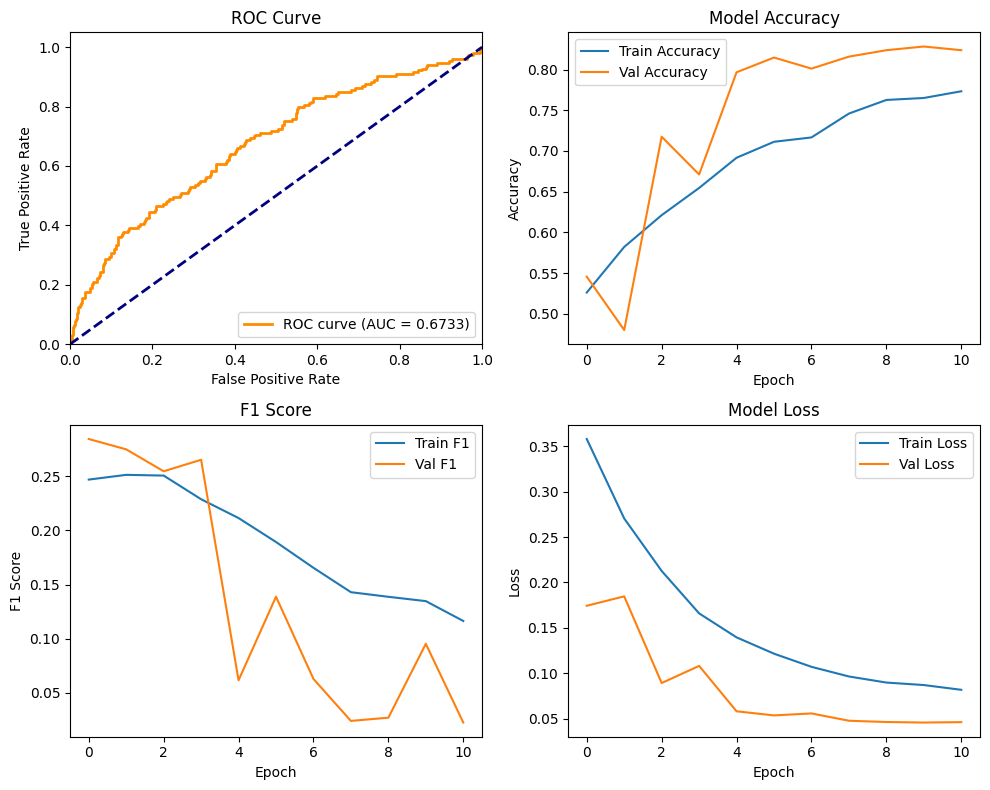


=== PREDICTION CONFIDENCE ANALYSIS ===
Average confidence: 0.6236
High confidence predictions (>0.8): 47 out of 885
Low confidence predictions (<0.6): 425 out of 885
Accuracy on high confidence predictions: 0.5319

=== CLINICAL RELEVANCE ===
False Negative Rate (missed 3rd degree burns): 0.2941
False Positive Rate (unnecessary ER referrals): 0.4536
Sensitivity for critical cases: 0.7059


In [9]:
# Load best ensemble model
best_ensemble = tf.keras.models.load_model(
    'best_ensemble_model_v3.h5',
    custom_objects={
        'focal_loss_fixed': focal_loss(focal_alpha, focal_gamma),
        'precision_metric': precision_metric,
        'recall_metric': recall_metric,
        'f1_metric': f1_metric
    }
)

# Predict on test set
test_preds = best_ensemble.predict(test_gen)
test_preds_main = test_preds[0] if isinstance(test_preds, list) else test_preds
test_preds_binary = (test_preds_main > 0.5).astype(int).flatten()

# Comprehensive evaluation
print("=== ENSEMBLE MODEL EVALUATION ===")
print("\nTest Set Classification Report:")
print(classification_report(
    test_df['binary_label'], 
    test_preds_binary,
    target_names=['1st/2nd Degree (Urgent Care)', '3rd Degree (ER)']
))

print("\nConfusion Matrix:")
cm = confusion_matrix(test_df['binary_label'], test_preds_binary)
print(cm)

# Calculate detailed metrics
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n=== DETAILED PERFORMANCE METRICS ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (3rd degree detection): {precision:.4f}")
print(f"Recall (3rd degree detection): {recall:.4f}")
print(f"Specificity (1st/2nd degree detection): {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")

# ROC AUC analysis
auc_score = roc_auc_score(test_df['binary_label'], test_preds_main.flatten())
print(f"ROC AUC Score: {auc_score:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(test_df['binary_label'], test_preds_main.flatten())
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Plot training history
plt.subplot(2, 2, 2)
plt.plot(history.history['main_output_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_main_output_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history.history['main_output_f1_metric'], label='Train F1')
plt.plot(history.history['val_main_output_f1_metric'], label='Val F1')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history.history['main_output_loss'], label='Train Loss')
plt.plot(history.history['val_main_output_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Confidence analysis
confidence_scores = np.max([test_preds_main.flatten(), 1 - test_preds_main.flatten()], axis=0)
print(f"\n=== PREDICTION CONFIDENCE ANALYSIS ===")
print(f"Average confidence: {np.mean(confidence_scores):.4f}")
print(f"High confidence predictions (>0.8): {np.sum(confidence_scores > 0.8)} out of {len(confidence_scores)}")
print(f"Low confidence predictions (<0.6): {np.sum(confidence_scores < 0.6)} out of {len(confidence_scores)}")

# Performance by confidence level
high_conf_mask = confidence_scores > 0.8
if np.sum(high_conf_mask) > 0:
    high_conf_acc = np.mean(test_df['binary_label'].values[high_conf_mask] == test_preds_binary[high_conf_mask])
    print(f"Accuracy on high confidence predictions: {high_conf_acc:.4f}")

print(f"\n=== CLINICAL RELEVANCE ===")
print(f"False Negative Rate (missed 3rd degree burns): {fn/(tp+fn):.4f}")
print(f"False Positive Rate (unnecessary ER referrals): {fp/(tn+fp):.4f}")
print(f"Sensitivity for critical cases: {recall:.4f}")

In [12]:
# Get predictions for threshold testing
val_preds = best_ensemble.predict(val_gen)
val_preds_main = val_preds[0] if isinstance(val_preds, list) else val_preds

print("=== THRESHOLD OPTIMIZATION ===")

# Test different thresholds
for thresh in [0.5, 0.4, 0.3, 0.25, 0.2]:
    print(f"\n--- Threshold {thresh} ---")
    val_preds_thresh = (val_preds_main > thresh).astype(int).flatten()
    print(classification_report(val_df['binary_label'], val_preds_thresh))
    print(confusion_matrix(val_df['binary_label'], val_preds_thresh))

# Test on test set with best threshold (usually 0.3 or 0.25 works well)
test_preds = best_ensemble.predict(test_gen)
test_preds_main = test_preds[0] if isinstance(test_preds, list) else test_preds

# Use threshold that maximizes recall for safety
optimal_thresh = 0.3
test_preds_final = (test_preds_main > optimal_thresh).astype(int).flatten()

print(f"\n=== FINAL TEST RESULTS (threshold={optimal_thresh}) ===")
print(classification_report(test_df['binary_label'], test_preds_final))
print(confusion_matrix(test_df['binary_label'], test_preds_final))

# Save model and results
best_ensemble.save('burn_model_v3_final.h5')
print(f"\n✓ Model saved as: burn_model_v3_final.h5")
print(f"✓ Use threshold {optimal_thresh} for predictions")

111/111 [==============================] - 11s 94ms/step
=== THRESHOLD OPTIMIZATION ===

--- Threshold 0.5 ---
              precision    recall  f1-score   support

           0       0.86      0.54      0.66       731
           1       0.21      0.59      0.31       154

    accuracy                           0.55       885
   macro avg       0.54      0.56      0.49       885
weighted avg       0.75      0.55      0.60       885

[[392 339]
 [ 63  91]]

--- Threshold 0.4 ---
              precision    recall  f1-score   support

           0       0.88      0.23      0.37       731
           1       0.19      0.86      0.31       154

    accuracy                           0.34       885
   macro avg       0.54      0.54      0.34       885
weighted avg       0.76      0.34      0.36       885

[[169 562]
 [ 22 132]]

--- Threshold 0.3 ---
              precision    recall  f1-score   support

           0       0.91      0.07      0.13       731
           1       0.18      0.97 